## Deep Neural Network in Numpy

In [629]:
%matplotlib inline
# All imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from IPython import display
import time

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(formatter={'float': '{:.4f}'.format})

In [630]:
def sigmoid(x):
    '''The logistic function as the sigmoid'''
    return 1.0/(1.0 + np.exp(-x))

def sigmoid_pr(z):
    '''derivative of the logistic function'''
    return z * (1 - z)

def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def tanh_pr(z):
    return 1-z**2

def relu(x):
    out = x
    out[out<0] = 0
    return out

def relu_pr(z):
    out = z
    out[out<0] = 0
    out[out>0] = 1
    return out

def leaky_relu(x, leak=0.05):
    out = x
    leaks = x*leak
    out[out<0] = leaks[out<0]
    return out

def leaky_relu_pr(z, leak=0.05):
    out = z
    out[out<0] = leak
    out[out==0] = 0
    out[out>0] = 1
    return out

def get_activations(name):
    if name == 'sigmoid':
        return sigmoid, sigmoid_pr
    elif name == 'tanh':
        return tanh, tanh_pr
    elif name == 'relu':
        return relu, relu_pr
    elif name == 'leaky_relu':
        return leaky_relu, leaky_relu_pr
    else:
        assert False, "Unknown Activation Function"

In [631]:
def xavier_init(fan_in, fan_out, scaling=0.1):
    std = np.sqrt(2/(fan_in+fan_out))
    return np.random.normal(0, std, (fan_in, fan_out)) * scaling

def random_init(fan_in, fan_out, scaling=0.1):
        return np.random.rand(fan_in,fan_out) * scaling

def get_weight_initialization(name):
    if name == 'xavier' or name == 'glorot':
         return xavier_init
    else:
         return random_init

In [632]:
def intermediate_results_print_callback(steps, step, X, a, y, rmse, verbose):
    if verbose:
        if step%(int(steps/10)) == 0:
            print("\nTraining Results (data, prediction, expected) at ",step,"epoch:")
            for x_print, p_print, y_print in zip(X, a, y):
                print(x_print[0:2],",",p_print , y_print)
            print("RMS_err:",np.round(rmse,4))

def early_stopping_on_success_callback(steps, step, tol, rmse, verbose):
    if step%(int(steps/10)) == 0:
        if rmse<tol:
            if verbose:
                print("\nNN training succeeded!")
            return True
    return False

def live_visualize_boundary_callback(steps, step, nn, data_points, thershold=0.5):
    if step%(int(steps/100)) == 0:
        y_data_points = nn.predict(data_points)
        y_class = np.zeros(y_data_points.shape)
        y_class[y_data_points<thershold] = 0
        y_class[y_data_points>=thershold] = 1
        plt.figure()
        plt.plot(data_points[y_class[:,0]==0][:,0], data_points[y_class[:,0]==0][:,1],'.', color='red')
        plt.plot(data_points[y_class[:,0]==1][:,0], data_points[y_class[:,0]==1][:,1],'.', color='blue')
        display.clear_output(wait=True) 
        display.display(plt.gcf())
        time.sleep(0.5)
        plt.clf()
        plt.show()

In [633]:
def get_data_points(Nsamp, dim=2):
    data_points = np.random.rand(Nsamp, dim)
    return data_points

In [634]:
# These codes are written by chatGPT. 
def moving_average(series, n=3, beta=0.1):
    """
    Calculate the simple moving average of a given timeseries.

    Parameters:
    series (list): The input timeseries to be smoothed.
    n (int): The window size to use for the moving average.

    Returns:
    list: A new list with the smoothed timeseries.
    """
    momemtum = 0
    for i in range(len(series)):
        series[i] = beta*series[i] + (1-beta)*momemtum
        
    cumsum = [0] * len(series)
    cumsum[n-1] = sum(series[:n])
    for i in range(n, len(series)):
        cumsum[i] = cumsum[i-1] + series[i] - series[i-n]
    return [round(c/n,2) for c in cumsum]

def momentum_moving_average(data, window_size=10, alpha=0.1):
    """
    Compute momentum-based moving average on a time series data.

    Args:
        data (list): the time series data to be smoothed.
        window_size (int): the size of the window used to calculate the moving average.
        alpha (float): the momentum factor.

    Returns:
        list: the smoothed time series data.
    """
    # Create an empty list to store the smoothed data
    smoothed_data = []

    # Initialize the first data point as the first value in the input data
    smoothed_data.append(data[0])

    # Compute the moving average for the remaining data points using momentum factor
    for i in range(1, len(data)):
        smoothed_data.append(alpha * data[i] + (1 - alpha) * smoothed_data[i - 1])

    # Compute the moving average for the first few data points
    for i in range(window_size, len(data)):
        smoothed_data[i] = alpha * data[i] + (1 - alpha) * smoothed_data[i - 1]

    # Return the smoothed data
    return smoothed_data

In [635]:
class NeuralNetwork:
    def __init__(self, layers, activation='sigmoid', deep_activation = 'tanh', initialization='random', callbacks=[]):
        '''
        Initialize the Neural Network.
        Note - Unlike common implementation, bias is a part of the weight matrix. For this inputs are appended with 1. 
        Tanh is the default activation function for hidden layers.
        Sigmoid is the default activation function for output layer.
        random initialization is the default weight and bias initialization method. Scaled down with a factor of 0.1
        No random seed is used, each initialization is new.
        '''
        self.W = []
        self.L = len(layers) - 1
    
        self.g = []
        self.g_prime = []
        self.callacks = callbacks
        for i in range(1, len(layers)):
            weight_init = get_weight_initialization(initialization)

            #add one extra neuron at input for the bias (layers[i-1] + 1)
            w = weight_init(layers[i-1]+1,layers[i])
            self.W.append(w)

            g, g_pr = get_activations(deep_activation) #this is for all the layers including the last layer. Last layer may be updated again.
            self.g.append(g)
            self.g_prime.append(g_pr)
        
        if deep_activation != activation:
            g, g_pr = get_activations(activation) #this is only for the last layer.
            self.g[self.L-1] = g
            self.g_prime[self.L-1] = g_pr

        assert len(self.W) == self.L

    def fit(self, X, y, learning_rate=1, steps=20000, tol=1e-2, verbose=True, lr_decay=False):
        '''
        Train the neural network
        '''

        # Change the shape of y in case it is a vector. 
        if y.ndim == 1:
            y = y.reshape((-1, 1)) 
   
        # History will keep the record of progress
        history = {'epochs':[],
                   'train_loss':[]}

        data_points = None
        
        # Training Steps
        for step in range(steps):
        
            history['epochs'].append(step)
            
            a = None
            A = [X]
            
            #This for loop is a forward pass step
            for i in range(len(self.W)):
                
                # adding the ones for the bias term.
                b = np.ones((A[i].shape[0],1))
                A[i] = np.concatenate((A[i],b),axis=1)
                
                # multiply weights with the inputs.
                a = self.g[i](np.dot(A[i], self.W[i]))
                A.append(a)

            assert y.shape == a.shape, "Output shape mismatched"
            
            rmse = self.find_RMS_error_y_pred(a, y)
            history['train_loss'].append(rmse)

            
            # Call the callbacks
            if 'intermediate_results_print' in self.callacks:
                intermediate_results_print_callback(steps, step, X, a, y, rmse, verbose)
                
            if 'early_stopping_on_success' in self.callacks:
                if early_stopping_on_success_callback(steps, step, tol, rmse, verbose):
                    return True, history
            
            if 'live_visualize_boundary' in self.callacks:
                if data_points is None:
                    data_points = get_data_points(Nsamp=2000)        
                live_visualize_boundary_callback(steps, step, self, data_points)

            # This part is the back-propogation step for updating the weights.
            # Weights are updated at each level, right after calculating the gradient, hence update steps at the level below is also affected. Not sure if this is right.
            error = y-A[self.L]

            delta = error * self.g_prime[self.L-1](A[self.L])

            delta_w = np.dot(A[self.L-1].T, delta)

            self.W[self.L-1] += delta_w * learning_rate

            delta_succ = delta

            for i in range(1, (len(self.W))):

                delta_curr = np.atleast_2d(self.g_prime[self.L-i-1](A[self.L-i]) * np.dot(delta_succ,self.W[self.L-i].T)) #2d for outer product

                delta_curr_mod = delta_curr[:,:-1] # Removing the delta for added bias placeholder - 1. not sure if right - ask Prof.

                delta_w = np.dot(A[self.L-i-1].T, delta_curr_mod)
                self.W[self.L-i-1] += delta_w * learning_rate

                delta_succ = delta_curr_mod
                
        if verbose:
            print("NN training failed!")
        
        return False, history
    
    def find_RMS_error(self, X, y):
        '''
        Predict using X and calculate RMSE
        '''
        if y.ndim == 1:
            y = y.reshape((-1, 1)) 
        y_pred = self.predict(X)
        return np.sqrt(np.mean(np.square(y-y_pred)))
    
    def find_RMS_error_y_pred(self, y_pred, y):
        '''
        calculate RMSE for given y_pred and y
        '''
        if y.ndim == 1:
            y = y.reshape((-1, 1)) 
        return np.sqrt(np.mean(np.square(y-y_pred)))

    def predict(self, x):
        '''
        Run the forward pass once and return the final output
        '''
        a = x
        for i in range(len(self.W)):
            b = np.ones((a.shape[0],1),dtype='int')
            a = np.concatenate((a,b),axis=1)
            a = self.g[i](np.dot(a, self.W[i]))
        return a
    
    def visual_NN_boundaries(self, Nsamp=2000, thershold=0.5):
        '''
        Visualize the line in the feature map space
        '''
        data_points = get_data_points(Nsamp)
        y_data_points = self.predict(data_points)
        y_class = np.zeros(y_data_points.shape)
        y_class[y_data_points<thershold] = 0
        y_class[y_data_points>=thershold] = 1
        
        plt.plot(data_points[y_class[:,0]==0][:,0], data_points[y_class[:,0]==0][:,1],'.', color='red')
        plt.plot(data_points[y_class[:,0]==1][:,0], data_points[y_class[:,0]==1][:,1],'.', color='blue')
        plt.show()


## Part I

In [636]:
X = np.array([[0, 0], 
              [1, 0], 
              [0, 1], 
              [1, 1]])
y = np.array([0, 1, 1, 0])

print("X\n",X.shape)
print("y\n",y.shape)

X
 (4, 2)
y
 (4,)


In [637]:
# Running the neural network 100 times and counting success.
sc = 0
n = 100
callbacks = ['early_stopping_on_success']
for _ in tqdm(range(n)):
    nn = NeuralNetwork([2,2,1], activation='sigmoid', deep_activation='tanh', initialization='random', callbacks=callbacks)
    success, _ = nn.fit(X, y, learning_rate=1, steps=20000, verbose=False)
    if success:
        sc += 1
print("Training Success Rate",(sc/n)*100,"%")


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]

Training Success Rate 100.0 %


In [638]:
callbacks = ['early_stopping_on_success', 'intermediate_results_print']
nn = NeuralNetwork([2,2,1], activation='sigmoid', callbacks=callbacks)
_ , history = nn.fit(X, y, steps=20000)


Training Results (data, prediction, expected) at  0 epoch:
[0 0] , [0.5259] [0]
[1 0] , [0.5271] [1]
[0 1] , [0.5264] [1]
[1 1] , [0.5276] [0]
RMS_err: 0.5007

Training Results (data, prediction, expected) at  2000 epoch:
[0 0] , [0.0191] [0]
[1 0] , [0.9856] [1]
[0 1] , [0.9856] [1]
[1 1] , [0.0200] [0]
RMS_err: 0.0172

Training Results (data, prediction, expected) at  4000 epoch:
[0 0] , [0.0123] [0]
[1 0] , [0.9908] [1]
[0 1] , [0.9908] [1]
[1 1] , [0.0127] [0]
RMS_err: 0.011

Training Results (data, prediction, expected) at  6000 epoch:
[0 0] , [0.0097] [0]
[1 0] , [0.9928] [1]
[0 1] , [0.9928] [1]
[1 1] , [0.0101] [0]
RMS_err: 0.0087

NN training succeeded!


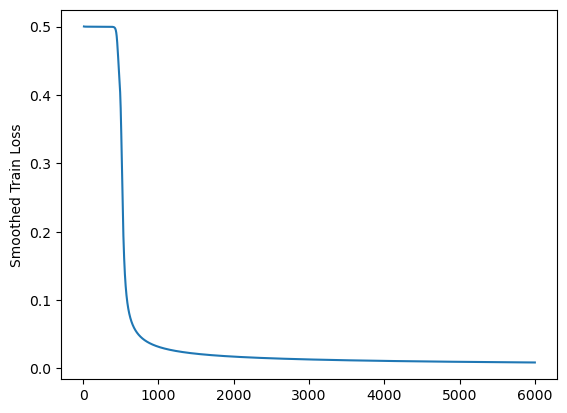

In [639]:
plt.plot(history['epochs'][10:],momentum_moving_average(history['train_loss'], window_size=10)[10:])
plt.ylabel('Epochs')
plt.ylabel('Smoothed Train Loss')
plt.show()

#### The unsmoothed history looks smoother than smoothed history. :) 

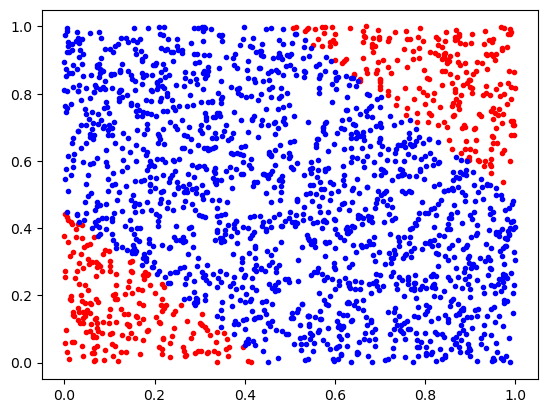

In [640]:
nn.visual_NN_boundaries()

## Part II

In [641]:
X = np.array([[0, 0],
[0, 1],
[0.5, 1],
[0, 0.5],
[1, 0],
[1, 1]])
y = np.array([0, 0, 0, 1, 1, 1])

In [642]:
# Running the nueral network 100 times and counting success.
sc = 0
n = 100
callbacks = ['early_stopping_on_success']
for _ in tqdm(range(n)):
    nn = NeuralNetwork([2,2,1], activation='sigmoid', deep_activation='tanh', initialization='random', callbacks=callbacks)
    success, _ = nn.fit(X, y, learning_rate=1, steps=20000, verbose=False)
    if success:
        sc += 1
print("Training Success Rate",(sc/n)*100,"%")


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]

Training Success Rate 53.0 %


In [643]:
# Increasing the complexity of NN in neuron size in a layer
# Running the nueral network 100 times and counting success.
sc = 0
n = 100
callbacks = ['early_stopping_on_success']
for _ in tqdm(range(n)):
    nn = NeuralNetwork([2,3,1], activation='sigmoid', deep_activation='tanh', initialization='random', callbacks=callbacks)
    success, _ = nn.fit(X, y, learning_rate=1, steps=20000, verbose=False)
    if success:
        sc += 1
print("Training Success Rate",(sc/n)*100,"%")


100%|██████████| 100/100 [00:13<00:00,  7.17it/s]

Training Success Rate 98.0 %


In [644]:
# Increasing the complexity of NN in depth dimension
# Running the nueral network 100 times and counting success.
sc = 0
n = 100
callbacks = ['early_stopping_on_success']
for _ in tqdm(range(n)):
    nn = NeuralNetwork([2,2,2,1], activation='sigmoid', deep_activation='tanh', initialization='random', callbacks=callbacks)
    success, _ = nn.fit(X, y, learning_rate=1, steps=20000, verbose=False)
    if success:
        sc += 1
print("Training Success Rate",(sc/n)*100,"%")


100%|██████████| 100/100 [01:24<00:00,  1.19it/s]

Training Success Rate 15.0 %


In [645]:
# Increasing the complexity of NN in both dimensions - depth and size of layers
# Running the nueral network 100 times and counting success.
sc = 0
n = 100
callbacks = ['early_stopping_on_success']
for _ in tqdm(range(n)):
    nn = NeuralNetwork([2,3,3,1], activation='sigmoid', deep_activation='tanh', initialization='random', callbacks=callbacks)
    success, _ = nn.fit(X, y, learning_rate=1, steps=20000, verbose=False)
    if success:
        sc += 1
print("Training Success Rate",(sc/n)*100,"%")


100%|██████████| 100/100 [00:29<00:00,  3.37it/s]

Training Success Rate 88.0 %


#### NeuralNetwork([2,3,1]) has best success rate. 
#### In some previous iterations, both NeuralNetwork([2,3,1]) and NeuralNetwork([2,3,3,1]) had similar performance, but [2,3,1] architecture is still selected. (Occam's razor)

In [651]:
callbacks = ['early_stopping_on_success', 'intermediate_results_print']
nn = NeuralNetwork([2,3,1], activation='sigmoid', deep_activation='tanh', initialization='random', callbacks=callbacks)
_ , history = nn.fit(X, y, steps=20000)


Training Results (data, prediction, expected) at  0 epoch:
[0.0000 0.0000] , [0.5191] [0]
[0.0000 1.0000] , [0.5227] [0]
[0.5000 1.0000] , [0.5237] [0]
[0.0000 0.5000] , [0.5209] [1]
[1.0000 0.0000] , [0.5211] [1]
[1.0000 1.0000] , [0.5246] [1]
RMS_err: 0.5003

Training Results (data, prediction, expected) at  2000 epoch:
[0.0000 0.0000] , [0.0173] [0]
[0.0000 1.0000] , [0.0142] [0]
[0.5000 1.0000] , [0.0131] [0]
[0.0000 0.5000] , [0.9783] [1]
[1.0000 0.0000] , [1.0000] [1]
[1.0000 1.0000] , [0.9906] [1]
RMS_err: 0.0143

Training Results (data, prediction, expected) at  4000 epoch:
[0.0000 0.0000] , [0.0107] [0]
[0.0000 1.0000] , [0.0090] [0]
[0.5000 1.0000] , [0.0088] [0]
[0.0000 0.5000] , [0.9863] [1]
[1.0000 0.0000] , [1.0000] [1]
[1.0000 1.0000] , [0.9931] [1]
RMS_err: 0.0092

NN training succeeded!


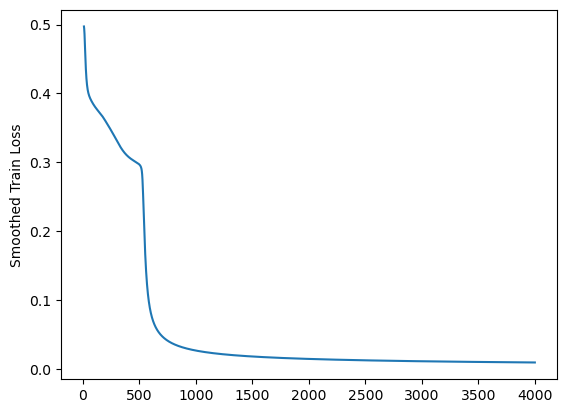

In [652]:
plt.plot(history['epochs'][10:],momentum_moving_average(history['train_loss'], window_size=10)[10:])
plt.ylabel('Epochs')
plt.ylabel('Smoothed Train Loss')
plt.show()

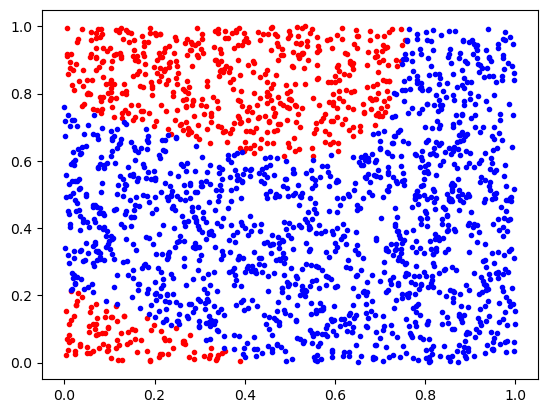

In [653]:
nn.visual_NN_boundaries()

## Bonus Part
Live update the training process.

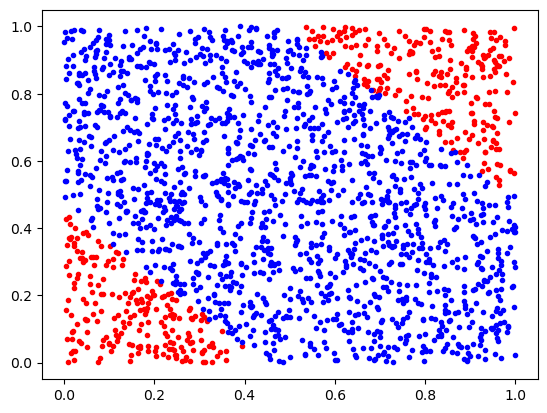

<Figure size 640x480 with 0 Axes>

In [654]:
X = np.array([[0, 0], 
              [1, 0], 
              [0, 1], 
              [1, 1]])
y = np.array([0, 1, 1, 0])

callbacks = ['early_stopping_on_success', 'live_visualize_boundary']
nn = NeuralNetwork([2,2,1], activation='sigmoid', callbacks=callbacks)
_ , history = nn.fit(X, y, steps=20000, verbose=False)

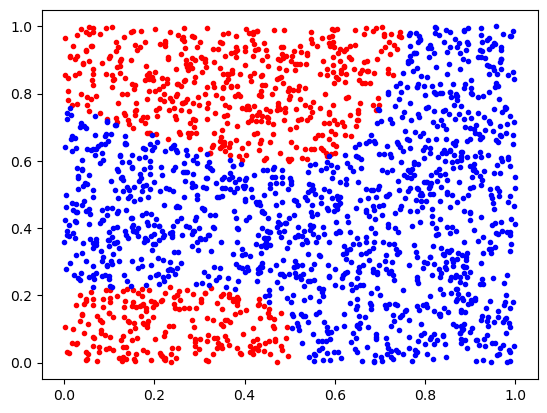

<Figure size 640x480 with 0 Axes>

In [655]:
X = np.array([[0, 0],
[0, 1],
[0.5, 1],
[0, 0.5],
[1, 0],
[1, 1]])
y = np.array([0, 0, 0, 1, 1, 1])

callbacks = ['early_stopping_on_success', 'live_visualize_boundary']
nn = NeuralNetwork([2,3,1], activation='sigmoid', deep_activation='tanh', initialization='random', callbacks=callbacks)
_ , history = nn.fit(X, y, steps=20000, verbose=False)